# Differential Equation Transformer

Here we fit a small GPT-2 style autoregressive transformer model to differential
equations over $n$ nodes $x_1, \dots, x_n$, where each $x_i\in \mathbb R$ with
interaction parameters $k_{ij}$ and $k'_{ij}$ for $i,j= 1\dots n$. 

We will use the 

$$
\dot x_i = 
\sum_{j=1}^N x_j k_{ji} \frac{1-x_i}{(1-x_i)+k_{ji}}
+
\sum_{j=1}^N x_j k'_{ji} \frac{x_i}{x_i+k_{ji}}
$$

 - **Key challenge**: the computational complexity of computing the differential state update for a given node $x_i$ scales linearly with $n$. I.e., computing $\dot x_i$ is an $\mathcal O(n)$ operation, making the computation of all $\dot x_i$ an $O(n^2)$ operation. 
 - **Solution**: include "register tokens" in the token sequence upon which we are training the autoregressive model. For each time $t=1, 2, \dots$, we would have tokens

$$
\text{input ids}(t) = 
\begin{pmatrix}
    <k_{11}, k_{21}, \dots, k_{n1}> x_1(t) 
\end{pmatrix}
\begin{pmatrix}
    <k_{12}, k_{22}, \dots, k_{n2}> x_2(t) 
\end{pmatrix}
\begin{pmatrix}
    \dots 
\end{pmatrix}
\begin{pmatrix}
    <k_{1n}, k_{2n}, \dots, k_{nn}> x_n(t)
\end{pmatrix}
$$

 - Terms in pointy braces $<>$ are "register tokens". That means they are not generated by the model (we add them manually during generation) and we don't train the output logits associated with them (the `labels` for these tokens are -100).

In [1]:
# Import box
import random
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import ast
import os
import pdb

import torch
from torch import nn
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, TrainingArguments, Trainer, GPT2PreTrainedModel, GPT2Model
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions, BaseModelOutputWithPastAndCrossAttentions

from dataclasses import dataclass
from typing import Optional, Tuple, Union
from transformers.utils import logging

logger = logging.get_logger(__name__)


In [2]:
# Constants
device='mps'

# Dynamical system parameters
k = torch.tensor([[0, 0.9, -0.13], [-0.13, 0, 0.23], [0.9, -0.13, 0]])
# k_prime = torch.tensor([[0, 0, 0.1], [0.1, 0, 0], [0, 0.1, 0]])
k_prime = torch.tensor([[0, 0, 0.0], [-0.0, 0, 0], [0, -0.0, 0]])
dt = 0.5
x0 = torch.tensor([0.75, 0.2, 0.1])
T = 10  #seconds 
n = x0.shape[0]
time = torch.arange(0, T, dt)
n_steps = time.shape[0]
assert time.shape[0] == n_steps
assert x0.shape[0] == n == k.shape[0] == k.shape[1]

num_decimals = 4 # Number of decimals to round to, zeros padded to this much
max_int = 2 # Maximum integer value for the input, zeros left-padded to this much


# Model parameters
d_model = 32 
n_layer = 3
n_head = 8
n_positions = 8192

## 1: Load Model

We will sub-class the GPT2LMHeadModel and add a linear projection so that the 
output is not a probability distribution over logits, but rather a scalar value. 

The loss can then be constructed in terms of the actual difference between the 
scalars. 

In [3]:
@dataclass
class ScalarOutput(BaseModelOutputWithPastAndCrossAttentions):
    """
    Base class for model outputs with scalar outputs.

    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*):
            Scalar regression loss.
        scalar_outputs (`torch.FloatTensor` of shape `(batch_size, sequence_length)`):
            Scalar outputs per token.
        past_key_values (`Tuple[Tuple[torch.FloatTensor]]`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
            Contains precomputed hidden-states (key and values in the attention blocks) as computed by the model.
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of each layer)
            of shape `(batch_size, sequence_length, hidden_size)`.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape
            `(batch_size, num_heads, sequence_length, sequence_length)`.
    """
    loss: Optional[torch.FloatTensor] = None
    scalar_outputs: torch.FloatTensor = None

class GPT2WithScalarHead(GPT2PreTrainedModel):
    """
    GPT2 model with an additional scalar projection layer.

    This model adds a linear layer (`scalar_head`)
    that projects the hidden states to scalar values for each token.

    Args:
        config (`GPT2Config`): Model configuration class with all the parameters of the model.
    """
    def __init__(self, config: GPT2Config):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        # Define the scalar projection layer
        self.scalar_head = nn.Linear(config.n_embd, 1, bias=True)
        # Initialize weights using the model's method
        self._init_weights(self.scalar_head)
        # Apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.FloatTensor] = None,  # Scalar labels per token
        label_mask: Optional[torch.BoolTensor] = None,  # Boolean mask indicating which labels to consider
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, ScalarOutput]:
        """
        Args:
            labels (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Scalar labels for computing the regression loss.
            label_mask (`torch.BoolTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Boolean mask indicating which labels to consider in the loss computation.
                `True` for tokens to include in loss, `False` to ignore.
            All other arguments are the same as in `GPT2Model`.

        Returns:
            `ScalarOutput` or a tuple, depending on `return_dict`.
        """
        # Set default value for return_dict
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Get transformer outputs
        transformer_outputs = self.transformer(
            input_ids=input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Hidden states from the last layer of the transformer
        hidden_states = transformer_outputs[0]  # (batch_size, sequence_length, hidden_size)

        # Compute scalar outputs
        scalar_outputs = self.scalar_head(hidden_states)  # (batch_size, sequence_length, 1)
        scalar_outputs = scalar_outputs.squeeze(-1)       # (batch_size, sequence_length)

        loss = None
        if labels is not None:
            # Ensure label_mask is provided
            if label_mask is None:
                raise ValueError("label_mask must be provided when labels are provided")

            # Apply label mask
            active_positions = label_mask.view(-1)  # Flattened mask
            if active_positions.sum() == 0:
                # No positions to compute loss
                loss = torch.tensor(0.0, device=scalar_outputs.device)
            else:
                # Flatten the scalar outputs and labels
                active_scalar_outputs = scalar_outputs.view(-1)[active_positions]
                active_labels = labels.view(-1)[active_positions]

                # Compute the loss (mean squared error)
                loss_fct = nn.MSELoss()
                loss = loss_fct(active_scalar_outputs, active_labels)

        if not return_dict:
            output = (scalar_outputs,) + transformer_outputs[1:]  # Exclude hidden_states from transformer_outputs
            return ((loss,) + output) if loss is not None else output

        # Return outputs as a dataclass instance
        return ScalarOutput(
            loss=loss,
            scalar_outputs=scalar_outputs,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
            cross_attentions=transformer_outputs.cross_attentions,
        )

In [4]:
config = GPT2Config(
    vocab_size=50257,  # Vocabulary size of the GPT-2 model
    n_embd=d_model,  # Hidden size of the transformer embeddings
    n_layer=n_layer,  # Number of transformer layers
    n_head=n_head,  # Number of attention heads
    n_positions=n_positions,  # Maximum sequence length
)

# creating the model, tokenizer
print("Creating model...")
model = GPT2WithScalarHead(config).to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
print("Done! model.device: ", model.device)
# size of model
print("Number of params:", sum(p.numel() for p in model.parameters()))

Creating model...
Done! model.device:  mps:0
Number of params: 1908577


For the tokenizer, we won't use the byte-pair-encoding tokenizer for GPT-2. We
will instead use a single character tokenizer. This makes mathematical
operations a bit easier, since each numeral corresponds to one token. 

In [5]:
def get_single_char_GPT2_tokenizer(): 
    """ Returns a dictionary compatable with `simple_tokenizer()` based on the 
    GPT-2 tokenizer with all the single-character tokens. 
    """
    # Load the GPT-2 tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    og_vocab_size = tokenizer.vocab_size
    # Save original special tokens
    original_special_tokens = tokenizer.all_special_tokens

    # Filter the vocabulary to include only single-character tokens
    filtered_vocab = {k: v for k, v in tokenizer.get_vocab().items() if len(k) == 1 or k in original_special_tokens}
    filtered_vocab[' '] = 220 # add space token

    return filtered_vocab

# get a tokenizer
tokenizer_dict = get_single_char_GPT2_tokenizer()

In [6]:
# Example forward pass

input_string = "Hello, world"
# use tokenizer dict
input_ids = [tokenizer_dict[c] for c in input_string]
input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
print("input_ids: ", input_ids)

labels = torch.randn(1, len(input_string)).to(device)
print("labels: ", labels)

# forward pass
output = model(input_ids, labels=labels, label_mask=(input_ids != tokenizer_dict[" "]))

print("output.keys(): ", output.keys())
print("output.scalar_outputs: ", output.scalar_outputs)
print("output.loss: ", output.loss)


input_ids:  tensor([[ 39,  68,  75,  75,  78,  11, 220,  86,  78,  81,  75,  67]],
       device='mps:0')
labels:  tensor([[-0.8297, -1.4971, -0.5247, -1.1591,  1.0787, -1.3428,  0.8924, -0.6065,
          0.8294, -0.3160,  1.3985, -0.5787]], device='mps:0')


/Users/aman/s4/dev/Teaching_LLMs/venv/lib/python3.12/site-packages/torch/_tensor_str.py:138: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:335.)
  nonzero_finite_vals = torch.masked_select(


output.keys():  odict_keys(['past_key_values', 'loss', 'scalar_outputs'])
output.scalar_outputs:  tensor([[-0.0210,  0.1308, -0.0826, -0.1669, -0.2094,  0.0329, -0.0408,  0.0149,
         -0.0852,  0.1202, -0.0695,  0.0881]], device='mps:0',
       grad_fn=<SqueezeBackward1>)
output.loss:  tensor(1.0953, device='mps:0', grad_fn=<MseLossBackward0>)


To do autoregressive generation, we will have to grab the scalar prediction for
the next $x_i(t)$ value, convert to string, then add as a set of tokens to the
input, then add the next set of register tokens $<k_{ji}>$, then ask for the
next prediction $x_{i+1}(t)$. 


During training, we just have to set up our `labels` and out `label_mask` so 
that the model is optimized to predict the true next $x_i(t)$, and we ignore 
predicting any $k_{ij}$ register tokens. 

## Generate Training Data

Here we will run the simulation from initial state `x0` for `T` seconds using 
interaction parameters `k` and `k_prime` with time discretization `dt`.

The goal is to construct a set of `input_ids` of the form described above, and 
a set of scalar `labels` and a `label_mask` such that the model can be trained 
to minimize the loss from 
`model(input_ids, labels=labels, label_mask=label_mask).loss`

In [7]:
# Function to simulate dynamics with optional progress bar
def simulate_dynamics(x0, k, k_prime, dt, T, max_int, num_decimals, progress=False):
    n_steps = int(T / dt)
    n = x0.shape[0]
    X = torch.zeros(n_steps, n)
    X[0] = x0
    max_value = 10 ** max_int - 10 ** (-num_decimals)
    print(max_value)
    iterator = range(1, n_steps)
    if progress:
        iterator = tqdm(iterator, desc="Simulating dynamics")
    for t in iterator:
        x_prev = X[t - 1]
        x_dot = torch.zeros_like(x_prev)
        for i in range(n):
            sum_k = 0
            sum_k_prime = 0
            for j in range(n):
                if k[j, i] != 0:
                    sum_k += x_prev[j] * k[j, i] * (1 - x_prev[i]) / ((1 - x_prev[i]) + k[j, i])
                if k_prime[j, i] != 0:
                    sum_k_prime += x_prev[j] * k_prime[j, i] * x_prev[i] / (x_prev[i] + k[j, i])
            x_dot[i] = sum_k + sum_k_prime
        x_new = x_prev + dt * x_dot
        # Clamp x_new to [0, max_value]
        print("Max value: ", max_value)
        x_new = torch.clamp(x_new, min=0, max=max_value)
        X[t] = x_new
    time = torch.arange(0, T, dt)
    return time, X

# Function to format numbers
def format_number(value, num_decimals, max_int):
    # Clamp the value
    max_value = 10 ** max_int - 10 ** (-num_decimals)
    value = max(0, min(value, max_value))
    # Split integer and decimal parts
    integer_part = int(value)
    decimal_part = value - integer_part
    # Left-pad integer part with zeros
    int_str = f"{integer_part:0{max_int}d}"
    # Format decimal part
    decimal_str = f"{decimal_part:.{num_decimals}f}"[2:]  # Remove "0."
    # Combine
    formatted = f"{int_str}.{decimal_str}"
    return formatted

# Function to construct sequences according to the desired format
def construct_sequences(time, X, k, k_prime, tokenizer_dict, num_decimals, max_int):
    data_points = []
    n_steps, n = X.shape
    for i in range(n):  # For each node
        sequence = ''
        labels = []
        label_mask = []
        for t in range(n_steps):
            # Interaction parameters for node i
            for j in range(n):
                # Include register tokens for k_{i}_{j} with values
                k_ij_value = format_number(k[i, j].item(), num_decimals, max_int)
                k_ij_token = f'<k_{i}_{j}={k_ij_value}>'
                sequence += k_ij_token
                label_mask.extend([False]*len(k_ij_token))
                # Include register tokens for k'_{i}_{j} with values
                k_prime_ij_value = format_number(k_prime[i, j].item(), num_decimals, max_int)
                k_prime_ij_token = f'<k\'_{i}_{j}={k_prime_ij_value}>'
                sequence += k_prime_ij_token
                label_mask.extend([False]*len(k_prime_ij_token))
            # Include 'x_{i}(t) = ' and the model is supposed to predict x_{i}(t)
            x_i_t_entry = f'x_{i}(t) = '
            sequence += x_i_t_entry
            label_mask.extend([False]*len(x_i_t_entry))
            # x_i(t) value
            x_i_t_str = format_number(X[t, i].item(), num_decimals, max_int)
            sequence += x_i_t_str
            label_mask.extend([True]*len(x_i_t_str))
            # Labels: set to x_i(t) for positions where label_mask is True, else -100
            labels.extend([-100.0]*(len(sequence) - len(labels) - len(x_i_t_str)))  # For previous tokens
            labels.extend([X[t, i].item()]*len(x_i_t_str))  # For x_i(t)
        # Tokenize sequence
        token_ids = []
        for char in sequence:
            if char in tokenizer_dict:
                token_ids.append(tokenizer_dict[char])
            else:
                raise ValueError(f"Unknown token: {char}")
        # Prepare data point
        data_point = {
            'input_ids': token_ids,
            'labels': labels,
            'label_mask': label_mask,
            'input_str': sequence  # Include the input string
        }
        data_points.append(data_point)
    return data_points

# Simulate dynamics (progress bar is optional)
time, X = simulate_dynamics(x0, k, k_prime, dt, T, max_int, num_decimals, progress=False)

# Construct sequences
data_points = construct_sequences(time, X, k, k_prime, tokenizer_dict, num_decimals, max_int)

# Save the dataset as jsonl
import json

with open('dataset.jsonl', 'w') as f:
    for data_point in data_points:
        f.write(json.dumps(data_point) + '\n')

# Now, let's check the first data point
first_data_point = data_points[0]
input_ids = first_data_point['input_ids']
labels = first_data_point['labels']
label_mask = first_data_point['label_mask']
input_str = first_data_point['input_str']

# Build inverse mapping for tokenizer_dict
inverse_tokenizer_dict = {v: k for k, v in tokenizer_dict.items()}
decoded_input_str = ''.join([inverse_tokenizer_dict[token_id] for token_id in input_ids])

print("Input String[:100]:")
print(input_str[:100])
print("\nLabels and Label Mask for positions corresponding to x_{i}(t):")
for idx, (char, lbl, mask) in enumerate(zip(decoded_input_str, labels, label_mask)):
    if mask:
        print(f"Position {idx}: '{char}' Label: {lbl}, Mask: {mask}")

# Verify that the decoded input string matches the original input string
assert input_str == decoded_input_str, "Decoded input string does not match the original input string."

99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Max value:  99.9999
Input String[:100]:
<k_0_0=00.0000><k'_0_0=00.0000><k_0_1=00.9000><k'_0_1=00.0000><k_0_2=00.0000><k'_0_2=00.0000>x_0(t) 

Labels and Label Mask for positions corresponding to x_{i}(t):
Position 102: '0' Label: 0.75, Mask: True
Position 103: '0' Label: 0.75, Mask: True
Position 104: '.' Label: 0.75, Mask: True
Position 105: '7' Label: 0.75, Mask: True
Position 106: '5' Label: 0.75, Mask: True
Position 107: '0' Label: 0.75, Mask: True
Position 108: '0' Label: 0.75, Mask: True
Position 211: '0' Label: 0.7326992750167847, Mask: True
Position 212: '0' Label: 0.7326992750167847, Mask: True
Position 213: '.' Lab

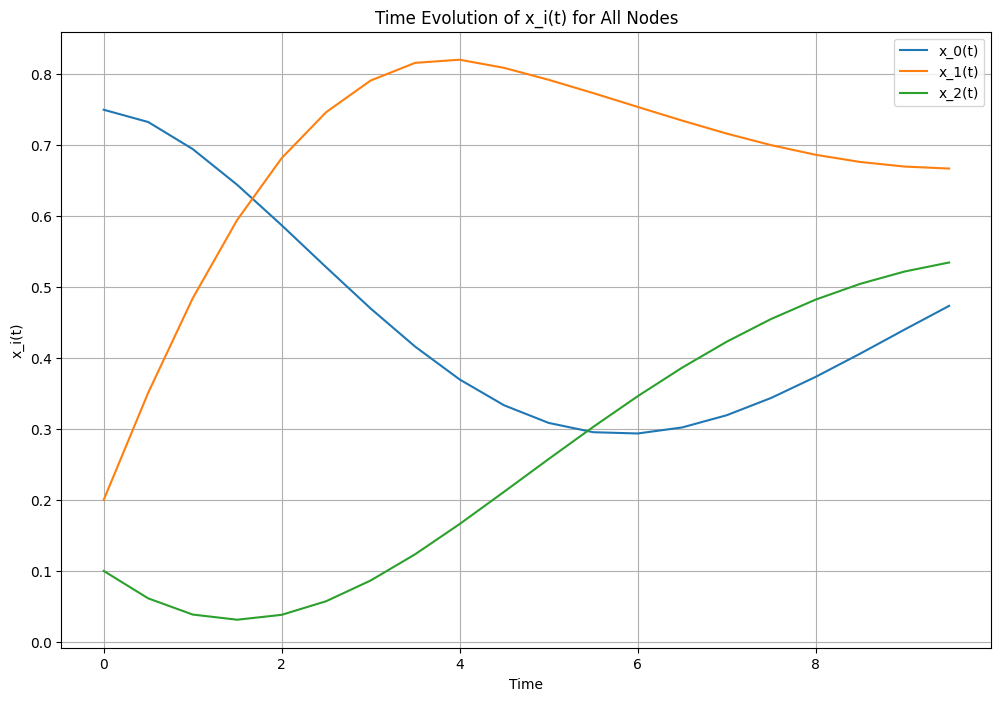

In [8]:
import re
import matplotlib.pyplot as plt

def plot_all_x_i_over_time(data_points, time):
    """
    Extracts x_i(t) values from the input strings of all data points and plots them over time.

    Args:
        data_points (list): List of data points, each containing 'input_str' for a node.
        time (torch.Tensor): The time vector.
    """
    plt.figure(figsize=(12, 8))
    for i, data_point in enumerate(data_points):
        input_str = data_point['input_str']
        # Regular expression pattern to extract x_i(t) values for node i
        pattern = rf'x_{i}\(t\) = (\d+\.\d+)'
        # Find all matches in the input string
        matches = re.findall(pattern, input_str)
        # Convert matches to floats
        x_i_values = [float(value) for value in matches]
        # Ensure time and x_i_values are the same length
        min_length = min(len(time), len(x_i_values))
        time_trimmed = time[:min_length]
        x_i_values = x_i_values[:min_length]
        # Plot x_i(t) vs time
        plt.plot(time_trimmed.numpy(), x_i_values, label=f'x_{i}(t)')
    plt.xlabel('Time')
    plt.ylabel('x_i(t)')
    plt.title('Time Evolution of x_i(t) for All Nodes')
    plt.legend()
    plt.grid(True)
    plt.show()


# run on the first data point
plot_all_x_i_over_time(data_points, time)

In [9]:
data_points[0]['input_str']
# check how many times x_{i}(t) appears in the input string for each i 
for i in range(3):
    count = 0
    for data_point in data_points:
        count += data_point['input_str'].count(f'x_{i}(t)')
    print(f"x_{i}(t) appears {count} times in the input strings.")

x_0(t) appears 20 times in the input strings.
x_1(t) appears 20 times in the input strings.
x_2(t) appears 20 times in the input strings.


## Overfit the Model

We will now over-fit the transformer model on the single trajectory of data points in `data_points`, stored in `dataset.jsonl`. 

We want to use the input_ids, labels, and label_mask to pass to the special new model class. Then minimize the loss, and plot the loss curves. 

In [10]:
from torch.utils.data import Dataset

class DifferentialEquationDataset(Dataset):
    def __init__(self, data_points):
        self.data_points = data_points

    def __len__(self):
        return len(self.data_points)

    def __getitem__(self, idx):
        data_point = self.data_points[idx]
        return {
            'input_ids': torch.tensor(data_point['input_ids'], dtype=torch.long),
            'labels': torch.tensor(data_point['labels'], dtype=torch.float32),
            'label_mask': torch.tensor(data_point['label_mask'], dtype=torch.bool)
        }

# Create the dataset
dataset = DifferentialEquationDataset(data_points)

# Define the data collator
def data_collator(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    label_mask = torch.stack([item['label_mask'] for item in batch])

    return {
        'input_ids': input_ids,
        'labels': labels,
        'label_mask': label_mask
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Directory to save model checkpoints
    per_device_train_batch_size=1,  # Batch size
    num_train_epochs=100,  # Overfitting by running multiple epochs
    logging_dir='./logs',  # Directory to save logs
    logging_steps=10,  # How often to log
    save_steps=50,  # Save checkpoints
    learning_rate=1e-3,  # A small learning rate to ensure smooth convergence
    no_cuda=False,  # Use GPU if available
)

# Custom Trainer class to handle additional arguments like `label_mask`
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        label_mask = inputs.get("label_mask")
        outputs = model(input_ids=inputs.get("input_ids"), labels=labels, label_mask=label_mask)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

# Initialize the trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator
)

# Train the model (this will overfit on the single trajectory data)
trainer.train()

# Save the model
model.save_pretrained('./overfitted_model')


  0%|          | 0/300 [00:00<?, ?it/s]

{'loss': 0.0932, 'grad_norm': 3.0238330364227295, 'learning_rate': 0.0009666666666666667, 'epoch': 3.33}
{'loss': 0.0509, 'grad_norm': 0.35240769386291504, 'learning_rate': 0.0009333333333333333, 'epoch': 6.67}
{'loss': 0.0617, 'grad_norm': 0.04018711671233177, 'learning_rate': 0.0009000000000000001, 'epoch': 10.0}
{'loss': 0.0568, 'grad_norm': 2.3493878841400146, 'learning_rate': 0.0008666666666666667, 'epoch': 13.33}
{'loss': 0.0517, 'grad_norm': 2.4004929065704346, 'learning_rate': 0.0008333333333333334, 'epoch': 16.67}
{'loss': 0.0579, 'grad_norm': 2.056546688079834, 'learning_rate': 0.0008, 'epoch': 20.0}
{'loss': 0.05, 'grad_norm': 0.08733206987380981, 'learning_rate': 0.0007666666666666667, 'epoch': 23.33}
{'loss': 0.054, 'grad_norm': 0.04866883531212807, 'learning_rate': 0.0007333333333333333, 'epoch': 26.67}
{'loss': 0.0513, 'grad_norm': 2.5426182746887207, 'learning_rate': 0.0007, 'epoch': 30.0}
{'loss': 0.0502, 'grad_norm': 1.5757066011428833, 'learning_rate': 0.000666666666